# Calculating the theoretical minimum age uncertainty.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import read_mist_models
from tqdm import tqdm, trange
import pandas as pd
from astropy.io import fits

plotpar = {'axes.labelsize': 30,
           'font.size': 25,
           'legend.fontsize': 15,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the MIST isochrones.

In [2]:
iso = read_mist_models.ISO("MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

Reading in: MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso


In [3]:
print('version: ', iso.version)
print('abundances: ', iso.abun)
print('rotation: ', iso.rot)
print('ages: ', [round(x,2) for x in iso.ages])
print('number of ages: ', iso.num_ages)
print('available columns: ', iso.hdr_list)

version:  {'MIST': '1.2', 'MESA': '7503'}
abundances:  {'[Fe/H]': 0.0, 'Yinit': 0.2703, 'Zinit': 0.0142857, '[a/Fe]': 0.0}
rotation:  0.0
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', '

Extract the data from the file and plot an HR diagram.

100%|██████████| 100/100 [00:00<00:00, 2681.11it/s]


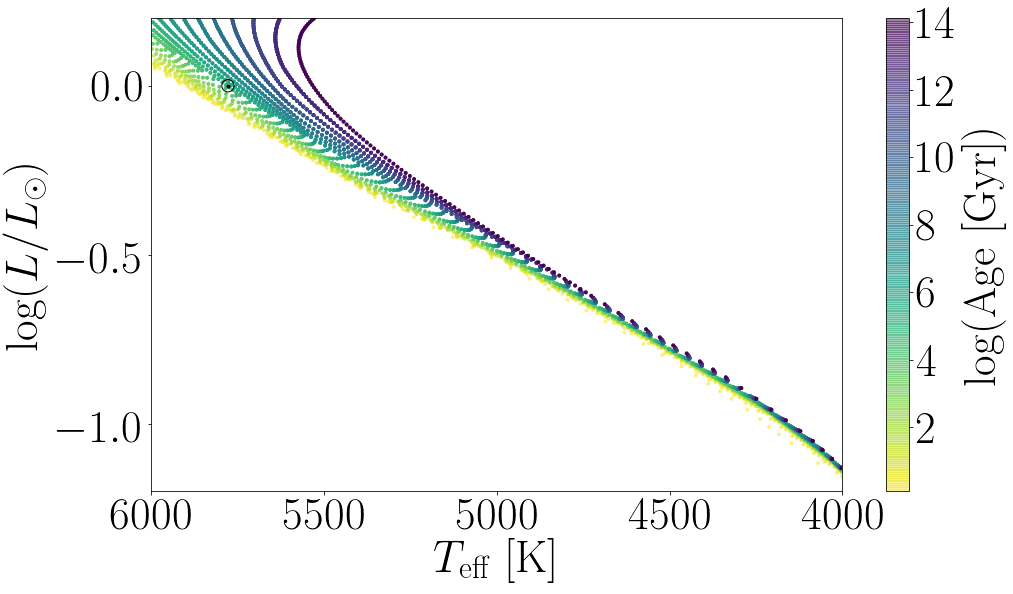

In [29]:
tmin, tmax = 4000, 6000
Lmin, Lmax = -1.2, .2

# zoom out
# tmin, tmax = 3800, 7500
# Lmin, Lmax = -1.2, .8

teffs, Ls, ages, G, bp, rp = [[] for i in range(6)]
for i, age in enumerate(tqdm(np.log10(np.linspace(.1, 13.8, 100)*1e9))):
    
    age_ind = iso.age_index(age) #returns the index for the desired age
    logTeff = iso.isos[age_ind]['log_Teff']
    logL = iso.isos[age_ind]['log_L']
    age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
    g = iso.isos[age_ind]["Gaia_G_DR2Rev"]
    _rp = iso.isos[age_ind]["Gaia_RP_DR2Rev"]
    _bp = iso.isos[age_ind]["Gaia_BP_DR2Rev"]
    
    teff = 10**logTeff
    m = (teff < tmax) * (tmin < teff)
    m &= (logL < Lmax) * (Lmin < logL)

    Ls.append(logL[m])
    teffs.append(teff[m])
    ages.append(age[m])
    G.append(g[m])
    rp.append(_rp[m])
    bp.append(_bp[m])

teffs = np.array([i for j in teffs for i in j])
Ls = np.array([i for j in Ls for i in j])
ages = np.array([i for j in ages for i in j])
G = np.array([i for j in G for i in j])
bp = np.array([i for j in bp for i in j])
rp = np.array([i for j in rp for i in j])

plotpar = {'axes.labelsize': 45,
           'font.size': 25,
           'legend.fontsize': 15,
           'xtick.labelsize': 45,
           'ytick.labelsize': 45,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 9))
plt.scatter(teffs, Ls, c=ages, s=8, cmap="viridis_r", alpha=.5, rasterized=True)   
plt.xlabel('$T_{\mathrm{eff}}~\mathrm{[K]}$')
plt.ylabel('$\log(L/L_\odot)$')
plt.xlim(tmax, tmin)
plt.ylim(Lmin, Lmax)
plt.colorbar(label="$\log(\mathrm{Age~[Gyr]})$")

# The sun
plt.plot(5778, 0, ".k")  # Casagrande 2018
plt.scatter(5778, 0, s=150, facecolors="none", edgecolors="k")

plt.subplots_adjust(left=.15, bottom=.15)

plt.savefig("hr_diagram.pdf")
plt.savefig("hr_diagram")

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(bp-rp, G, c=ages, s=8, cmap="viridis_r", alpha=.5, rasterized=True)   
plt.xlabel('$T_{\mathrm{eff}}~\mathrm{[K]}$')
plt.ylabel('$\log(L/L_\odot)$')
plt.xlim(tmax, tmin)
plt.ylim(Lmin, Lmax)
plt.colorbar(label="$\log(\mathrm{Age~[Gyr]})$")

# The sun
plt.plot(5778, 0, ".k")  # Casagrande 2018
plt.scatter(5778, 0, s=150, facecolors="none", edgecolors="k")

plt.subplots_adjust(left=.15, bottom=.15)

plt.savefig("hr_diagram.pdf")
plt.savefig("hr_diagram")

Now plot a color-magnitude diagram in Gaia pass-bands.

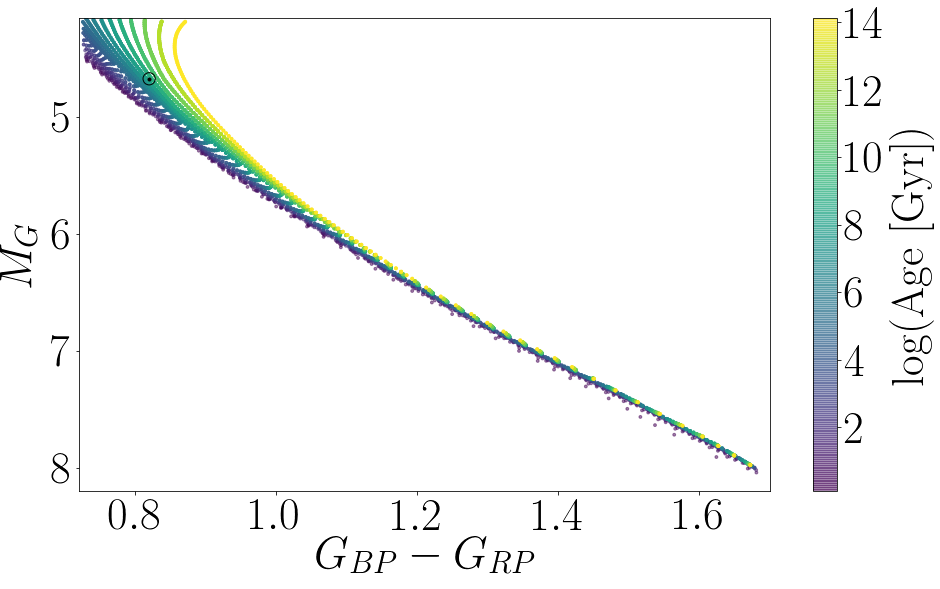

In [34]:
gmax, gmin = 8.2, 4.15
bprpmin, bprpmax = .72, 1.7

plt.figure(figsize=(16, 9))
plt.scatter(bp-rp, G, c=ages, s=8, cmap="viridis", alpha=.5, rasterized=True)   
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.colorbar(label="$\log(\mathrm{Age~[Gyr]})$")

# The Sun
plt.plot(.82, 4.67, ".k")  # Casagrande 2018
plt.scatter(.82, 4.67, s=150, facecolors="none", edgecolors="k")

plt.subplots_adjust(left=.15, bottom=.15)

plt.savefig("CMD.pdf")
plt.savefig("CMD")

Calculate the uncertainty on age given an uncertainty on $T_{\mathrm{eff}}$ and $\log(L)$.

In [9]:
def calc_Cq(x, y, z, dx, dy, xerr, yerr):
    """
    Calculate numerical derivatives dx/dz and dy/dz and fisher information.
    Returns the minimum theoretical uncertainty on z, sqrt(Cq), given 
    uncertainties on x (xerr) and y (yerr) and derivatives dx/dz and dy/dz.
    """

    assert dx > min(np.diff(x)), "dx should be > {}".format(min(np.diff(x)))
    assert dy > min(np.diff(y)), "dy should be > {}".format(min(np.diff(y)))
    
    Cq = np.zeros(len(x))
    for i in trange(len(x)):
    
        # Make a little box around each data point
        m = (x[i] - dx*.5 < x) * (x < x[i] + dx*.5)
        m &= (y[i] - dy*.5 < y) * (y < y[i] + dy*.5)
    
        # Fit a plane to the data (i.e. calculate derivatives)
        A = np.vstack((np.ones_like(x[m]), x[m], y[m])).T
        ATA = np.dot(A.T, A)
        a, b, c = np.linalg.solve(ATA, np.dot(A.T, z[m]))
        
        dydq = np.array([1./b, 1./c])  # Matrix of partial derivatives of data (y) w.r.t. params (q).
        Cy = np.diag([xerr**2, yerr**2])  # Covariance matrix of data
        
        Cq[i] = 1./np.dot(dydq, np.linalg.solve(Cy, dydq))  # Calculate variance of param

    return np.sqrt(np.array(Cq))

Choose uncertainties on $T_{\mathrm{eff}}$ and $\log(L)$.

In [10]:
terr, lerr = 50, .05
xerr, yerr = terr, lerr
dx, dy = 100, .1
x, y, z = teffs, Ls, ages
Cq = calc_Cq(x, y, z, dx, dy, xerr, yerr)

100%|██████████| 8466/8466 [00:00<00:00, 8780.34it/s]


Plot an HR diagram coloured by the minimum theoretical age uncertainty.

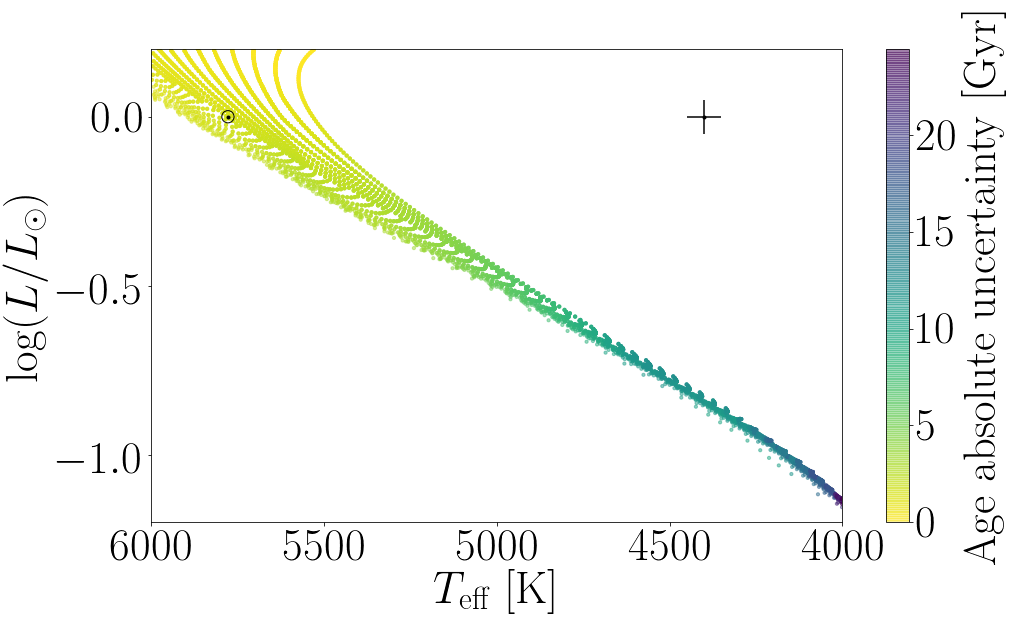

In [26]:
plt.figure(figsize=(16, 9))
plt.scatter(teffs, Ls, c=Cq, s=10, alpha=.5, cmap="viridis_r", rasterized=True)
plt.xlim(tmax, tmin)
plt.ylim(Lmin, Lmax)
plt.colorbar(label="$\mathrm{Age~absolute~uncertainty~[Gyr]}$")
plt.errorbar((tmax - tmin)*.2 + tmin, 0, xerr=terr, yerr=lerr, fmt=".", color="k")

plt.xlabel('$T_{\mathrm{eff}}~\mathrm{[K]}$')
plt.ylabel('$\log(L/L_\odot)$')

# The sun
plt.plot(5778, 0, ".k")  # Casagrande 2018
plt.scatter(5778, 0, s=150, facecolors="none", edgecolors="k")

plt.subplots_adjust(left=.15, bottom=.15)

plt.savefig("fisher_hr_diagram")
plt.savefig("fisher_hr_diagram.pdf")

In [ ]:
plotpar = {'axes.labelsize': 30,
           'font.size': 25,
           'legend.fontsize': 15,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Now do the same for the CMD.

In [31]:
gerr, bprperr = .05, .05  # These uncertainties calculated from typical Gaia G abs mag uncertainties in DR2 (see below).
xerr, yerr = gerr, bprperr
dx, dy = .1, .1
x, y, z = bp-rp, G, ages
Cq_cmd = calc_Cq(x, y, z, dx, dy, xerr, yerr)

100%|██████████| 8466/8466 [00:01<00:00, 7085.49it/s]


0.007363247755522054


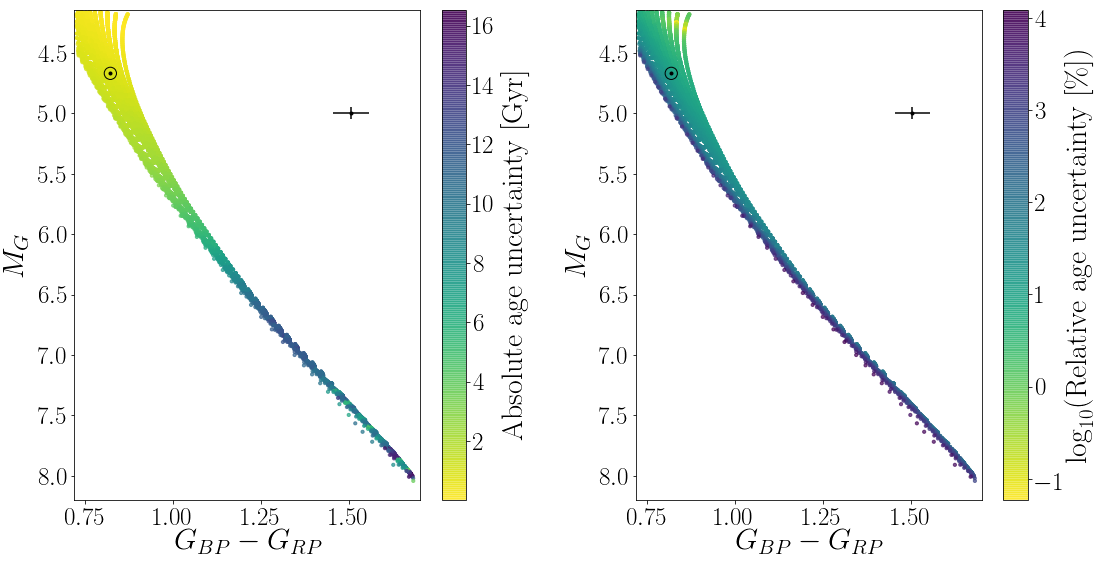

In [56]:
# plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.scatter(bp[::-1]-rp[::-1], G[::-1], c=Cq_cmd[::-1], s=10, alpha=.7, cmap="viridis_r")
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.colorbar(label="$\mathrm{Absolute~age~uncertainty~[Gyr]}$")
plt.errorbar((bprpmax - bprpmin)*.8 + bprpmin, 5, xerr=bprperr, yerr=gerr, fmt=".", color="k", 
            label="$\mathrm{Typical~Gaia~uncertainties}$")
print(min(Cq_cmd))

# The Sun
plt.plot(.82, 4.67, ".k")  # Casagrande 2018
plt.scatter(.822, 4.67, s=150, facecolors="none", edgecolors="k")

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")

plt.subplot(1, 2, 2)
plt.scatter(bp[::-1]-rp[::-1], G[::-1], c=np.log10((Cq_cmd[::-1]/ages[::-1])*100), 
            s=10, alpha=.7, cmap="viridis_r")#, vmax=200)
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.colorbar(label="$\log_{10}(\mathrm{Relative~age~uncertainty~[\%]})$")
plt.errorbar((bprpmax - bprpmin)*.8 + bprpmin, 5, xerr=bprperr, yerr=gerr, fmt=".", color="k")

# The sun
plt.plot(.82, 4.67, ".k")  # Casagrande 2018
plt.scatter(.82, 4.67, s=150, facecolors="none", edgecolors="k")

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.subplots_adjust(left=.1, bottom=-.5, right=2.4, top=1.2, wspace=.3)

plt.savefig("iso_fisher")
# plt.savefig("iso_fisher.pdf")

# Now calculate the age uncertainty from gyrochronology.

$$ P = a A^n (C - c)^b$$

$$ C = \left(\frac{P}{a}\right)^{1/b}A^{b/n} + c$$

We want to calculate 
$$ \frac{dP}{dA},$$

$$\frac{dC}{dA} $$

$$ \frac{dP}{dA} = anA(C - c)^b$$

$$ \frac{dC}{dA} =  \frac{b}{n}\left(\frac{P}{a}\right)^{1/b}A^{b/n - 1}$$

Or

$$ A = a + bC + cC^2 + dC^3 + eC^4 + fP $$

$$ P = \frac{A - a - bC - cC^2 - dC^3 - eC^4}{f}$$

$$ \frac{\delta P}{\delta A} = \frac{1}{f}$$

$$ \frac{\delta C}{\delta A} = \frac{1}{b + 2cC + 3dC^2 + 4eC^3} $$

In [51]:
# Calculate the gyrochronology derivatives
def ddA(A, C, P):
    """
    dP/dA = (P/A) * d(logP)/d(logA)
    d(logP)/dA = 1/A * d(logP)/d(logA)
    dC/dA = (C/A) * d(logC)/d(logA)
    """
    p = [-25.6052148, 71.35038675, -47.34007546, 11.16382679, 1.49]
    a, b, c, d, f = p
    
    dlogA_dlogP = f
    dlogP_dlogA = 1./dlogA_dlogP
    dP_dA = (P/A) * dlogP_dlogA
    
    dlogA_dlogC = b + 2*c*np.log10(C) + 3*d*(np.log10(C))**2 # + 4*e*(np.log10(C))**3
    dlogC_dlogA = 1./dlogA_dlogC
    dC_dA = (C/A) * dlogC_dlogA
    
    return dP_dA, dC_dA

# Calculate the Fisher information for both gyrochronology and isochronology.
def calc_Cq_iso_gyro(x, y, z, params, dx, dy, xerr, yerr, perr):
    """
    x, y, z, p = BP - RP, G, age, period
    xerr, yerr, perr = bprperr, gerr, perr
    params = a, b, c, d, e, f (weights for the gyrochronology polynomial)
    """
    
    assert dx > min(np.diff(x)), "dx should be > {}".format(min(np.diff(x)))
    assert dy > min(np.diff(y)), "dy should be > {}".format(min(np.diff(y)))
    
    Cq = np.zeros(len(x))
    for i in trange(len(x)):
    
        # Calculate numerical gradients for the CMD
        
        # Make a little box around the data point
        m = (x[i] - dx*.5 < x) * (x < x[i] + dx*.5)
        m &= (y[i] - dy*.5 < y) * (y < y[i] + dy*.5)
    
        # Fit a plane to the data
        A = np.vstack((np.ones_like(x[m]), x[m], y[m])).T
        ATA = np.dot(A.T, A)
        a, b, c = np.linalg.solve(ATA, np.dot(A.T, z[m]))
        dxdz_iso = 1./b
        dydz = 1./c
        
        dpdz, dxdz_gyro = ddA(z[i], x[i], y[i])
        
        dydq = np.array([dxdz_iso+dxdz_gyro, dydz, dpdz])
        Cy = np.diag([xerr**2, yerr**2, perr**2])
        
        Cq[i] = 1./np.dot(dydq, np.linalg.solve(Cy, dydq))

    return np.sqrt(np.array(Cq))

In [52]:
params = [-25.6052148, 71.35038675, -47.34007546, 11.16382679, 1.49]
age_err = calc_Cq_iso_gyro(bp - rp, G, ages, params, .1, .1, .05, .05, 1.)
print(age_err)

100%|██████████| 8466/8466 [00:01<00:00, 7664.45it/s]

[0.0187147  0.01918686 0.01939814 ... 0.18118771 0.19721098 0.16542641]


0.058488257478041705


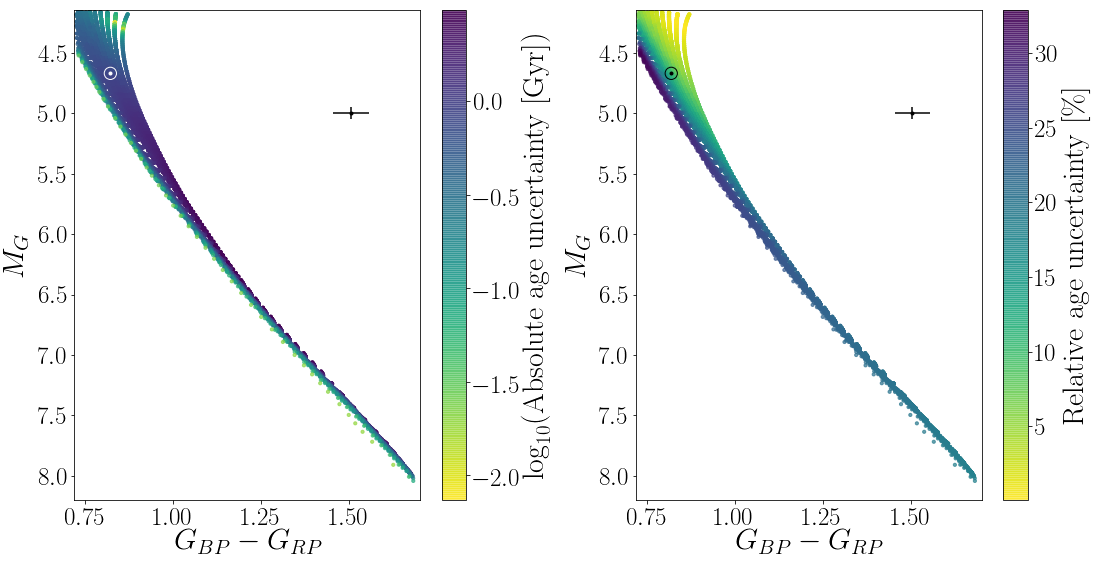

In [57]:
plt.subplot(1, 2, 1)
plt.scatter(bp[::-1]-rp[::-1], G[::-1], c=np.log10(age_err[::-1]), s=10, alpha=.7, 
            cmap="viridis_r")#, vmin=.1999, vmax=.209)
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.colorbar(label="$\log_{10}(\mathrm{Absolute~age~uncertainty~[Gyr]})$")
plt.errorbar((bprpmax - bprpmin)*.8 + bprpmin, 5, xerr=bprperr, yerr=gerr, fmt=".", color="k")

# The sun
plt.plot(.82, 4.67, ".w")  # Casagrande 2018
plt.scatter(.822, 4.67, s=150, facecolors="none", edgecolors="w")

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")

plt.subplot(1, 2, 2)
plt.scatter(bp[::-1]-rp[::-1], G[::-1], c=(age_err[::-1]/ages[::-1])*100, s=10, alpha=.7, 
            cmap="viridis_r")#, vmin=.1999, vmax=.209)
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.colorbar(label="$\mathrm{Relative~age~uncertainty~[\%]}$")
plt.errorbar((bprpmax - bprpmin)*.8 + bprpmin, 5, xerr=bprperr, yerr=gerr, fmt=".", color="k")

print(min((age_err[::-1]/ages[::-1])*100))

# The sun
plt.plot(.82, 4.67, ".k")  # Casagrande 2018
plt.scatter(.82, 4.67, s=150, facecolors="none", edgecolors="k")

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")

plt.subplots_adjust(left=.1, bottom=-.5, right=2.4, top=1.2, wspace=.3)
plt.savefig("gyro_fisher")
# plt.savefig("gyro_fisher.pdf")

#### Plot the increased precision factor.

In [ ]:
plt.figure(figsize=(10, 10))
inds = np.arange(len(G))[::-1]
plt.scatter((bp-rp)[inds], G[inds], c=np.log10(age_err/Cq_cmd)[inds], s=30, alpha=.3,
            edgecolor="none", vmin=-1.5)#, vmax=-.5)
plt.errorbar((bprpmax - bprpmin)*.8 + bprpmin, 5, xerr=bprperr, yerr=gerr, fmt=".", color="k")
plt.ylim(gmax, gmin)
plt.xlim(bprpmin, bprpmax)
plt.colorbar(label="$\log_{10}(\mathrm{Fractional~reduction~in~age~uncertainty})$")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("fractional_reduction.pdf")

What are some typical uncertainties for Gaia-Kepler stars?

Load the Gaia-Kepler catalogue.

In [ ]:
with fits.open("kepler_dr2_1arcsec.fits") as data:
    df = pd.DataFrame(data[1].data)

In [ ]:
delta_mag = 2.5*np.log10((df.phot_g_mean_flux_error + df.phot_g_mean_flux) / df.phot_g_mean_flux)
m = delta_mag < .001
plt.hist(delta_mag[m], 100);
plt.axvline(np.median(delta_mag), color="tab:orange")
print(np.median(delta_mag))

So the uncertainty on apparent magnitude is very small. What about the uncertainty on abs mag that comes from parallax uncertainties?

In [ ]:
m = 1. < df.phot_g_mean_flux.values - df.phot_rp_mean_mag.values
m &= 5.5 < df.phot_g_mean_mag.values

parallax = df.parallax.values[m]
parallax_err = df.parallax_error.values[m]
gmag = df.phot_g_mean_mag.values[m]

N = 1000
sig = np.zeros(N)
for i in range(N):
    plx = parallax_err[i] * np.random.randn(N) + parallax[i]
    M = gmag[i] - 5*np.log10(plx) - 5
    sig[i] = np.std(M)
    
sigs = sig[np.isfinite(sig)]
plt.hist(sigs, 100);
plt.xlim(0, .2)
med = np.median(sigs)
plt.axvline(med, color="tab:orange")
print(med)

In [ ]:
dpda = 10
perr = 1
aerr = perr/dpda
aerr

In [ ]:
print(1./f)

In [ ]:
type(iso)

In [ ]:
save_iso = pd.DataFrame(dict({"age": (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9,
                              "G": iso.isos[age_ind]["Gaia_G_DR2Rev"],
                              "rp": iso.isos[age_ind]["Gaia_RP_DR2Rev"],
                              "bp": iso.isos[age_ind]["Gaia_BP_DR2Rev"],
                              "logL": iso.isos[age_ind]['log_L'],
                              "logTeff": iso.isos[age_ind]['log_Teff']}))

save_iso.to_csv("feh0_iso.csv")

Calculating the rate of change in rotation period for the Sun.

$$\frac{dP}{dt} = naA^{n-1}(C-c)^b$$

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


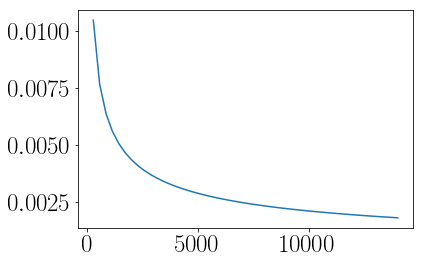

In [66]:
n, a, b, c = .55, .4, .31, .45
plt.plot(x, (.65 - c)**b * n*a*x**(n-1))

In [74]:
# 1Gyr old Sun
print((.65 - c)**b * n*a*1000**(n-1) * 1000)

5.966806847850824


In [76]:
# 2 Gyr old Sun
print((.65 - c)**b * n*a*2000**(n-1) * 1000)

4.367958278204399


In [77]:
# 3 Gyr old Sun
print((.65 - c)**b * n*a*3000**(n-1) * 1000)

3.639463890803466


In [78]:
# 4 Gyr old Sun
print((.65 - c)**b * n*a*4000**(n-1) * 1000)

3.1975326178031716


In [75]:
# Today's Sun
print((.65 - c)**b * n*a*4567**(n-1) * 1000)

3.012367991370065


In [ ]:
# 10 Gyr old Sun
print((.65 - c)**b * n*a*10000**(n-1) * 1000)

What are the average uncertainties on Prot in the McQuillan catalogue?

0.132


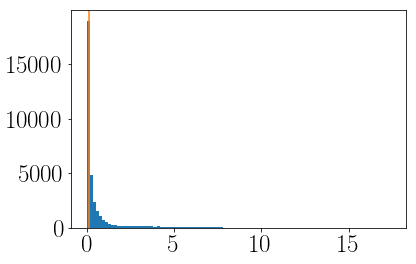

In [89]:
mc = pd.read_csv("../data/Table_1_Periodic.txt")
plt.hist(mc.Prot_err, 100);
print(np.median(mc.Prot_err))
plt.axvline(np.median(mc.Prot_err), color="tab:orange")